In [1]:
import pandas as pd
import sklearn 
import scipy
from sklearn import linear_model as lm
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cross_validation import KFold, train_test_split, cross_val_score, StratifiedKFold, LabelKFold, ShuffleSplit
from sklearn.metrics import roc_auc_score
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from mhcflurry.amino_acid import common_amino_acids
from mhcflurry import dataset
from mhcflurry.dataset import Dataset
import matplotlib.pyplot as plt 
% matplotlib inline
import numpy as np
import math 
from mhcflurry import peptide_encoding, amino_acid
import statsmodels.api as sm
from keras import models, layers, optimizers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, Input, merge, Convolution1D, AveragePooling1D, Activation, Flatten
from keras.preprocessing import sequence
from keras.models import Model
from keras.engine import topology
import seaborn as sns

Using Theano backend.


In [2]:
df = pd.read_table("bdata.2009.mhci.public.1.txt")

df['log_meas']=1-np.log(df['meas'])/math.log(50000)
df['peptide_length'] = df['sequence'].str.len()


max_len=df['sequence'].str.len().max()
n_peptides = df['sequence'].count()

def amino_acid_hotshot_encoding(s):
    return common_amino_acids.hotshot_encoding([s],len(s)).flatten().astype(int)
df['hotshot_encoded_peptides'] = df.sequence.apply(lambda seq: amino_acid_hotshot_encoding(seq))

def amino_acid_index_encoding(s, maxlen):
    a = 1+common_amino_acids.index_encoding([s],len(s)).flatten()
    return np.concatenate([a, np.zeros(maxlen-len(a),dtype=int)])
df['index_encoded_peptides'] = df.sequence.apply(lambda seq: amino_acid_index_encoding(seq, max_len))

def measured_affinity_less_than(Y,k):
    IC50 = 50000**(1-Y)
    return (IC50 < k).astype(int) 

def affinity_label(Y):
    return measured_affinity_less_than(Y,50) + measured_affinity_less_than(Y,500) + measured_affinity_less_than(Y,5000) + measured_affinity_less_than(Y,50000)

df['affinity_label'] = affinity_label(df['log_meas'])
df_h = df[df['mhc']=='HLA-A-0201'][['hotshot_encoded_peptides','index_encoded_peptides','log_meas','peptide_length']]
X = np.array(list(df_h['index_encoded_peptides']))
y = np.array(list(df_h['log_meas']))
y[y<0]=0

def first_and_last_three(Y):
    k = np.count_nonzero(Y)
    return np.concatenate([Y[:3],Y[-3+k:k]])
def first_and_last_four(Y):
    k = np.count_nonzero(Y)
    return np.concatenate([Y[:4],Y[-4+k:k]])
def first_and_last_two(Y):
    k = np.count_nonzero(Y)
    return np.concatenate([Y[:2],Y[-2+k:k]])
X_44 = np.apply_along_axis(first_and_last_four,1,X)
X_33 = np.apply_along_axis(first_and_last_three,1,X)
X_22 = np.apply_along_axis(first_and_last_two,1,X)

In [4]:
folds = 3
batch_size_nn = 16
batch_size_lstm = 16
hidden = 50
dropout_probability = 0.25
embedding_dropout = 0.25
n_epochs = 50
epoch = 0

test_lstm_bi_embedded_aucs = np.zeros((folds,n_epochs))
train_lstm_bi_embedded_aucs = np.zeros((folds,n_epochs))

train_bi_lstm_aucs = np.zeros((folds,n_epochs))
test_bi_lstm_aucs = np.zeros((folds,n_epochs))


train_lstm_aucs = np.zeros((folds,n_epochs))
test_lstm_aucs = np.zeros((folds,n_epochs))


for i, (train_idx, test_idx) in enumerate(KFold(len(df_h),folds, shuffle=True)):
    #lstm_bi_embedded
    sequence = Input( shape= (26, ),dtype='int32')
    embedded = Embedding(input_dim = 21, input_length = 26, output_dim= 32,mask_zero = True)(sequence)
    embedded2 = Embedding(input_dim = 21, input_length = 26, output_dim= 32,mask_zero = True)(sequence)
    
    forwards = LSTM(hidden, dropout_W = 0.5, dropout_U = 0.5)(embedded)
    
    backwards = LSTM(hidden,dropout_W = 0.5,dropout_U = 0.5, go_backwards=True)(embedded2)
  
    merged = merge([forwards, backwards], mode = 'concat', concat_axis=-1)
    after_dp = Dropout(dropout_probability)(merged)
    output = Dense(1, activation = 'sigmoid')(after_dp)
    lstm_bi_embedded = Model(input = sequence, output = output)
    
    lstm_bi_embedded.compile(optimizer = 'adam', loss='mean_squared_error')
    #bi_lstm
    sequence = Input( shape= (26, ),dtype='int32')
    embedded = Embedding(input_dim = 21, input_length = 26, output_dim= 32,mask_zero = True)(sequence)
    forwards = LSTM(hidden, dropout_W = 0.5, dropout_U = 0.5)(embedded)
    backwards = LSTM(hidden, dropout_W = 0.5,dropout_U = 0.5, go_backwards=True)(embedded)

    merged = merge([forwards, backwards], mode = 'concat', concat_axis=-1)
    after_dp = Dropout(dropout_probability)(merged)
    output = Dense(1, activation = 'sigmoid')(after_dp)
    bi_lstm = Model(input = sequence, output = output)
    
    bi_lstm.compile(optimizer = 'adam', loss='mean_squared_error')
    # lstm 
    sequence = Input( shape= (26, ),dtype='int32')
    embedded = Embedding(input_dim = 21, input_length = 26, output_dim= 32,mask_zero = True)(sequence)
    forwards = LSTM(hidden, dropout_W = 0.5, dropout_U = 0.5)(embedded)

    after_dp = Dropout(dropout_probability)(forwards)
    output = Dense(1, activation = 'sigmoid')(after_dp)
    lstm = Model(input = sequence, output = output)
    
    lstm.compile(optimizer = 'adam', loss='mean_squared_error')
    
    for epoch in range(n_epochs):
        
        
        #lstm3ffn3
        lstm_bi_embedded.fit(X[train_idx],y[train_idx], batch_size = batch_size_lstm, nb_epoch=1)
    
        train_lstm_bi_embedded_auc = roc_auc_score(measured_affinity_less_than(y[train_idx],500),lstm_bi_embedded.predict(X[train_idx]))
        test_lstm_bi_embedded_auc = roc_auc_score(measured_affinity_less_than(y[test_idx],500),lstm_bi_embedded.predict(X[test_idx]))
        
        train_lstm_bi_embedded_aucs[i][epoch]=train_lstm_bi_embedded_auc
        test_lstm_bi_embedded_aucs[i][epoch]=test_lstm_bi_embedded_auc
        
        #bi_lstm 
        bi_lstm.fit(X[train_idx],y[train_idx], batch_size = batch_size_lstm, nb_epoch=1)
    
        train_bi_lstm_auc = roc_auc_score(measured_affinity_less_than(y[train_idx],500),bi_lstm.predict(X[train_idx]))
        test_bi_lstm_auc = roc_auc_score(measured_affinity_less_than(y[test_idx],500),bi_lstm.predict(X[test_idx]))
        
        train_bi_lstm_aucs[i][epoch]=train_bi_lstm_auc
        test_bi_lstm_aucs[i][epoch]=test_bi_lstm_auc
        
        #lstm
        
        lstm.fit(X[train_idx],y[train_idx], batch_size = batch_size_lstm, nb_epoch=1)
        train_lstm_auc = roc_auc_score(measured_affinity_less_than(y[train_idx],500),lstm.predict(X[train_idx]))
        test_lstm_auc = roc_auc_score(measured_affinity_less_than(y[test_idx],500),lstm.predict(X[test_idx]))
        
        train_lstm_aucs[i][epoch]=train_lstm_auc
        test_lstm_aucs[i][epoch]=test_lstm_auc
        
        print(test_lstm_bi_embedded_auc, test_bi_lstm_auc,  test_lstm_auc, epoch, i)


train_lstm_bi_embedded_aucs_mean = np.mean(train_lstm_bi_embedded_aucs, axis=0)
test_lstm_bi_embedded_aucs_mean = np.mean(test_lstm_bi_embedded_aucs, axis=0)


train_bi_lstm_aucs_mean = np.mean(train_bi_lstm_aucs, axis=0)
test_bi_lstm_aucs_mean = np.mean(test_bi_lstm_aucs, axis=0)

train_lstm_aucs_mean = np.mean(train_lstm_aucs, axis=0)
test_lstm_aucs_mean = np.mean(test_lstm_aucs, axis=0)

Epoch 1/1
6376/6376 [==============================] - 14s - loss: 0.0708    
Epoch 1/1
6376/6376 [==============================] - 14s - loss: 0.0709    
Epoch 1/1
6376/6376 [==============================] - 7s - loss: 0.0744     
0.844954469463 0.847967500016 0.827921285917 0 0
Epoch 1/1
6376/6376 [==============================] - 12s - loss: 0.0570    
Epoch 1/1
6376/6376 [==============================] - 12s - loss: 0.0569    
Epoch 1/1
6376/6376 [==============================] - 8s - loss: 0.0595     
0.851313375729 0.858174900526 0.84983053937 1 0
Epoch 1/1
6376/6376 [==============================] - 13s - loss: 0.0534    
Epoch 1/1
6376/6376 [==============================] - 12s - loss: 0.0533    
Epoch 1/1
6376/6376 [==============================] - 8s - loss: 0.0546     
0.859008130357 0.865430478252 0.859697052824 2 0
Epoch 1/1
6376/6376 [==============================] - 13s - loss: 0.0516    
Epoch 1/1
6376/6376 [==============================] - 12s - loss: 0.0515 

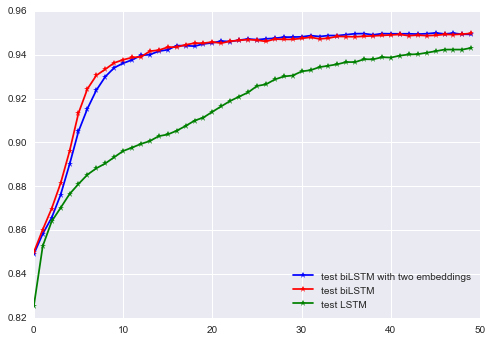

In [8]:
plt.plot( np.arange(0,50,1), test_lstm_bi_embedded_aucs_mean[0:50],color='b',marker='*', linestyle='-', label ="test biLSTM with two embeddings")
plt.plot( np.arange(0,50,1), test_bi_lstm_aucs_mean[0:50],color='r',marker='*', linestyle='-', label ="test biLSTM")
plt.plot( np.arange(0,50,1), test_lstm_aucs_mean[0:50],color='g',marker='*', linestyle='-', label ="test LSTM")
plt.legend(loc=4)

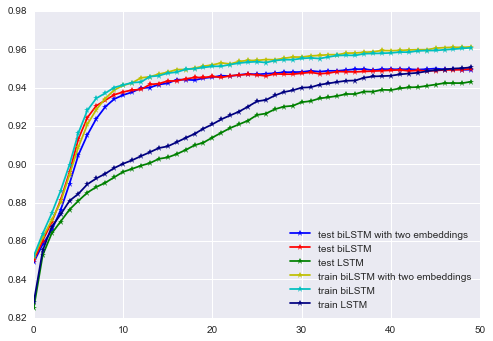

In [9]:
plt.plot( np.arange(0,50,1), test_lstm_bi_embedded_aucs_mean[0:50],color='b',marker='*', linestyle='-', label ="test biLSTM with two embeddings")
plt.plot( np.arange(0,50,1), test_bi_lstm_aucs_mean[0:50],color='r',marker='*', linestyle='-', label ="test biLSTM")
plt.plot( np.arange(0,50,1), test_lstm_aucs_mean[0:50],color='g',marker='*', linestyle='-', label ="test LSTM")
plt.plot( np.arange(0,50,1), train_lstm_bi_embedded_aucs_mean[0:50],color='y',marker='*', linestyle='-', label ="train biLSTM with two embeddings")
plt.plot( np.arange(0,50,1), train_bi_lstm_aucs_mean[0:50],color='c',marker='*', linestyle='-', label ="train biLSTM")
plt.plot( np.arange(0,50,1), train_lstm_aucs_mean[0:50],color='navy',marker='*', linestyle='-', label ="train LSTM")
plt.legend(loc=4)